# Data Augmentation

This notebook demonstrates the data augmentation process that increases the training dataset by a minimum of 40%.

**Note:** Conservative augmentation settings are used to maintain model accuracy while achieving 40% dataset increase.

## Augmentation Techniques:
1. **Rotation** (-40° to +40°): Handles orientation variations (conservative range)
2. **Flipping** (Horizontal & Vertical): Captures mirror variations
3. **Scaling** (85% to 115%): Represents size/distance variations (tighter range)
4. **Color Jitter** (Brightness, Contrast): Simulates lighting variations (conservative settings)


# Import Libraries

In [1]:
import sys
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

# Add src to path to import augmentation module
sys.path.append(str(Path('../src').resolve()))
import numpy as np

# Patch np.bool for compatibility
if not hasattr(np, 'bool'):
    np.bool = bool
import imgaug.augmenters as iaa

# Set matplotlib backend
%matplotlib inline


C:\Users\MOHAMED\AppData\Local\Temp\ipykernel_23388\3875764041.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not hasattr(np, 'bool'):


## Data Paths and Configuration


In [2]:
# Define paths
raw_data_dir = Path('../data/raw')
output_dir = Path('../data/augmented')
reports_dir = Path('../reports')
TARGET_INCREASE = 0.40  # 40% increase with conservative settings
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Create output directories
output_dir.mkdir(parents=True, exist_ok=True)
reports_dir.mkdir(parents=True, exist_ok=True)
for class_name in classes:
    (output_dir / class_name).mkdir(parents=True, exist_ok=True)

print(f"Raw data directory: {raw_data_dir}")
print(f"Output directory: {output_dir}")

Raw data directory: ..\data\raw
Output directory: ..\data\augmented


## Count Original Images


In [3]:
original_counts = {}
total_original = 0

for class_name in classes:
    class_dir = raw_data_dir / class_name
    if class_dir.exists():
        images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
        count = len(images)
        original_counts[class_name] = count
        total_original += count
        print(f"{class_name:12} : {count:4} images")

print(f"{'Total':12} : {total_original:4} images")
print(f"\n Total original images: {total_original}")


cardboard    :  259 images
glass        :  401 images
metal        :  328 images
paper        :  476 images
plastic      :  386 images
trash        :  110 images
Total        : 1960 images

 Total original images: 1960


## Define Augmentation Pipeline

In [4]:
print("Defining augmentation pipeline...")
print("Using conservative settings to maintain accuracy with 40% increase\n")
print("Augmentation Techniques:")

# 1. Rotation (-40° to +40°) - Conservative range
rotation = iaa.Sometimes(0.65, iaa.Affine(
    rotate=(-40, 40),  # Slightly less rotation for better accuracy
    mode='reflect',
    fit_output=False
))
print("\n1. Rotation:")
print("   Range: -40° to +40° (conservative)")
print("   Probability: 65%")
print("   Justification: Handles orientation variations with reduced distortion")

# 2. Flipping
flip_horizontal = iaa.Fliplr(p=0.5)
flip_vertical = iaa.Flipud(p=0.3)  # Reduced vertical flip probability
print("\n2. Flipping:")
print("   Horizontal flip: 50% probability")
print("   Vertical flip: 30% probability")
print("   Justification: Captures mirror variations and different viewing perspectives")

# 3. Scaling (85% to 115%) - Tighter range
scaling = iaa.Sometimes(0.5, iaa.Affine(
    scale={"x": (0.85, 1.15), "y": (0.85, 1.15)},  # Tighter range
    mode='reflect',
    fit_output=False
))
print("\n3. Scaling:")
print("   Range: 85% to 115% of original size (conservative)")
print("   Probability: 50%")
print("   Justification: Represents size variations with less distortion")

# 4. Color Jitter - Conservative settings
color_jitter = iaa.Sometimes(0.55, iaa.Sequential([
    iaa.Multiply((0.75, 1.25)),  # More conservative brightness (75-125%)
    iaa.LinearContrast((0.8, 1.4))  # More conservative contrast (80-140%)
]))
print("\n4. Color Jitter:")
print("   Brightness: 75-125% (conservative)")
print("   Contrast: 80-140% (conservative)")
print("   Probability: 55%")
print("   Justification: Simulates lighting conditions with realistic variations")

# Combine all techniques using Sequential (matches Python file structure)
augmentation_pipeline = iaa.Sequential([
    rotation,
    flip_horizontal,
    flip_vertical,
    scaling,
    color_jitter
])

print("\n" + "=" * 60)
print("✓ Augmentation pipeline configured for 40% increase")
print("  Conservative settings maintain accuracy")
print("=" * 60)


Defining augmentation pipeline...
Using conservative settings to maintain accuracy with 40% increase

Augmentation Techniques:

1. Rotation:
   Range: -40° to +40° (conservative)
   Probability: 65%
   Justification: Handles orientation variations with reduced distortion

2. Flipping:
   Horizontal flip: 50% probability
   Vertical flip: 30% probability
   Justification: Captures mirror variations and different viewing perspectives

3. Scaling:
   Range: 85% to 115% of original size (conservative)
   Probability: 50%
   Justification: Represents size variations with less distortion

4. Color Jitter:
   Brightness: 75-125% (conservative)
   Contrast: 80-140% (conservative)
   Probability: 55%
   Justification: Simulates lighting conditions with realistic variations

✓ Augmentation pipeline configured for 40% increase
  Conservative settings maintain accuracy


## Calculate Augmentation Requirements

In [5]:
target_total = int(total_original * (1 + TARGET_INCREASE))
images_to_generate = target_total - total_original

augmentation_factors = {}
for class_name in classes:
    original_count = original_counts[class_name]
    if original_count > 0:
        min_per_class = int(original_count * TARGET_INCREASE)
        proportion = original_count / total_original
        proportional_count = int(images_to_generate * proportion)
        augmentation_factors[class_name] = max(min_per_class, proportional_count)
        print(f"{class_name:12} : {original_count:4} original → {augmentation_factors[class_name]:4} augmented")
    else:
        augmentation_factors[class_name] = 0
        print(f"{class_name:12} : {'0':>4} original → {'0':>4} augmented")

print("-" * 50)
total_to_generate = sum(augmentation_factors.values())
print(f"{'Total':12} : {total_original:4} original → {total_to_generate:4} augmented")
print(f"\n Will generate {total_to_generate} augmented images")


cardboard    :  259 original →  103 augmented
glass        :  401 original →  160 augmented
metal        :  328 original →  131 augmented
paper        :  476 original →  190 augmented
plastic      :  386 original →  154 augmented
trash        :  110 original →   44 augmented
--------------------------------------------------
Total        : 1960 original →  782 augmented

 Will generate 782 augmented images


## Visualize Augmentation Techniques


Sample image from 'cardboard' class
Original image shape: (384, 512, 3)


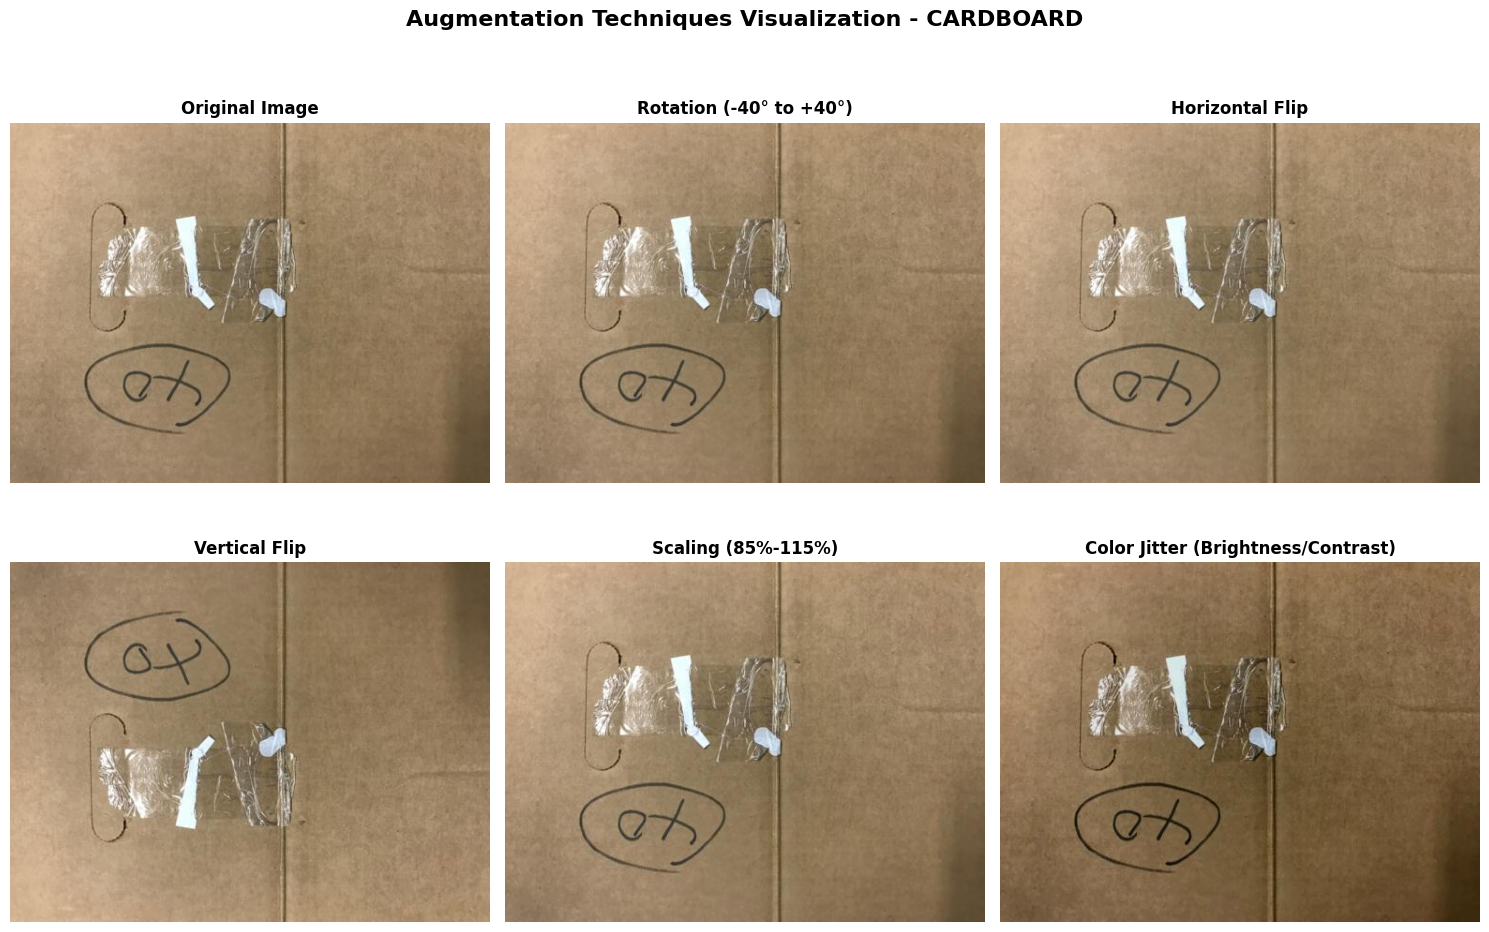


✓ Visualization saved to reports/augmentation_techniques_visualization.png


In [6]:
# Load a sample image for visualization
sample_class = 'cardboard'
sample_class_dir = raw_data_dir / sample_class

if sample_class_dir.exists():
    sample_images = list(sample_class_dir.glob('*.jpg')) + list(sample_class_dir.glob('*.png'))
    
    if len(sample_images) > 0:
        sample_img_path = sample_images[0]
        img = cv2.imread(str(sample_img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        print(f"Sample image from '{sample_class}' class")
        print(f"Original image shape: {img_rgb.shape}")
        
        # Create visualizations for each technique
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Original
        axes[0, 0].imshow(img_rgb)
        axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
        axes[0, 0].axis('off')
        
        # Rotation (conservative)
        rotated = iaa.Sometimes(0.65, iaa.Affine(rotate=(-40, 40), mode='reflect'))(image=img_rgb)
        axes[0, 1].imshow(rotated)
        axes[0, 1].set_title('Rotation (-40° to +40°)', fontsize=12, fontweight='bold')
        axes[0, 1].axis('off')
        
        # Horizontal Flip
        flipped_h = flip_horizontal(image=img_rgb)
        axes[0, 2].imshow(flipped_h)
        axes[0, 2].set_title('Horizontal Flip', fontsize=12, fontweight='bold')
        axes[0, 2].axis('off')
        
        # Vertical Flip
        flipped_v = flip_vertical(image=img_rgb)
        axes[1, 0].imshow(flipped_v)
        axes[1, 0].set_title('Vertical Flip', fontsize=12, fontweight='bold')
        axes[1, 0].axis('off')
        
        # Scaling (conservative)
        scaled = iaa.Sometimes(0.5, iaa.Affine(scale={"x": (0.85, 1.15), "y": (0.85, 1.15)}, mode='reflect'))(image=img_rgb)
        axes[1, 1].imshow(scaled)
        axes[1, 1].set_title('Scaling (85%-115%)', fontsize=12, fontweight='bold')
        axes[1, 1].axis('off')
        
        # Color Jitter (conservative)
        jittered = color_jitter(image=img_rgb)
        axes[1, 2].imshow(jittered)
        axes[1, 2].set_title('Color Jitter (Brightness/Contrast)', fontsize=12, fontweight='bold')
        axes[1, 2].axis('off')
        
        plt.suptitle(f'Augmentation Techniques Visualization - {sample_class.upper()}', 
                     fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.savefig(reports_dir / 'augmentation_techniques_visualization.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print("\n✓ Visualization saved to reports/augmentation_techniques_visualization.png")
    else:
        print(f"No images found in {sample_class_dir}")
else:
    print(f"Class directory {sample_class_dir} does not exist")


## Show Multiple Augmentation Examples


dict_keys(['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'])


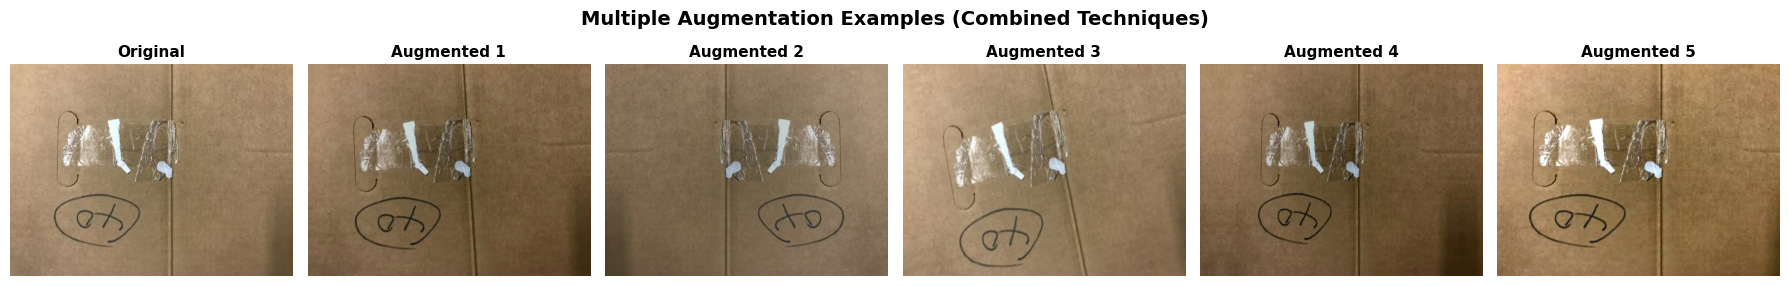

✓ Augmentation examples saved to reports/augmentation_examples.png


In [7]:
# Show multiple augmented versions of the same image
print(original_counts.keys())

if sample_class_dir.exists() and len(sample_images) > 0:
    img = cv2.imread(str(sample_img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig, axes = plt.subplots(1, 6, figsize=(18, 3))
    
    # Original
    axes[0].imshow(img_rgb)
    axes[0].set_title('Original', fontsize=11, fontweight='bold')
    axes[0].axis('off')
    
    # 5 augmented versions
    for i in range(1, 6):
        augmented = augmentation_pipeline(image=img_rgb)
        axes[i].imshow(augmented)
        axes[i].set_title(f'Augmented {i}', fontsize=11, fontweight='bold')
        axes[i].axis('off')
    
    plt.suptitle('Multiple Augmentation Examples (Combined Techniques)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(reports_dir / 'augmentation_examples.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Augmentation examples saved to reports/augmentation_examples.png")


In [8]:
import sys
print(sys.executable)  # Should point to your venv Python
import numpy as np
print(np.__version__)  # Should be 1.24.3
import imgaug
print(imgaug.__version__)  # Recommended >=0.4.0


d:\self-project\material-stream-identification-system\venv\Scripts\python.exe
1.23.5
0.4.0


## Run Full Data Augmentation

**Note:** This step will actually generate and save augmented images. Progress bars will show the status.


In [9]:
print("Starting full dataset augmentation...")
print("=" * 70)

augmented_counts = {}
total_augmented = 0

for class_name in classes:
    class_dir = raw_data_dir / class_name
    output_class_dir = output_dir / class_name
    num_augmented = augmentation_factors[class_name]
    
    if num_augmented == 0:
        print(f"\nSkipping {class_name} (no images to augment)")
        augmented_counts[class_name] = 0
        continue
    
    if not class_dir.exists():
        print(f"\nWarning: {class_dir} does not exist. Skipping...")
        augmented_counts[class_name] = 0
        continue
    
    # Get all images in the class
    image_files = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
    
    if len(image_files) == 0:
        print(f"\nWarning: No images found in {class_dir}. Skipping...")
        augmented_counts[class_name] = 0
        continue
    
    print(f"\n{'='*70}")
    print(f"Augmenting {class_name.upper()} class")
    print(f"  Original images: {len(image_files)}")
    print(f"  Target augmented images: {num_augmented}")
    print(f"{'='*70}")
    
    augmented_count = 0
    image_idx = 0
    
    # Progress bar
    pbar = tqdm(total=num_augmented, desc=f"  Processing {class_name}", unit="img")
    
    while augmented_count < num_augmented:
        # Cycle through original images
        img_file = image_files[image_idx % len(image_files)]
        
        # Load image
        img = cv2.imread(str(img_file))
        if img is None:
            image_idx += 1
            continue
        
        # Convert BGR to RGB for imgaug
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Apply augmentation
        augmented_img = augmentation_pipeline(image=img_rgb)
        
        # Convert back to BGR for saving with OpenCV
        augmented_img_bgr = cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR)
        
        # Save augmented image
        base_name = img_file.stem
        output_path = output_class_dir / f"{base_name}_aug_{augmented_count:04d}.jpg"
        
        # Ensure directory exists
        output_path.parent.mkdir(parents=True, exist_ok=True)
        
        # Save the image
        success = cv2.imwrite(str(output_path), augmented_img_bgr)
        
        if not success:
            print(f"\nWarning: Failed to save {output_path}")
        
        augmented_count += 1
        image_idx += 1
        pbar.update(1)
    
    pbar.close()
    augmented_counts[class_name] = augmented_count
    total_augmented += augmented_count
    
    print(f" Generated {augmented_count} augmented images for {class_name}")
    print(f"  Saved to: {output_class_dir}")

print("\n" + "=" * 70)
print("Augmentation Complete!")
print("=" * 70)


Starting full dataset augmentation...

Augmenting CARDBOARD class
  Original images: 259
  Target augmented images: 103


  Processing cardboard: 100%|██████████| 103/103 [00:03<00:00, 29.06img/s]


 Generated 103 augmented images for cardboard
  Saved to: ..\data\augmented\cardboard

Augmenting GLASS class
  Original images: 401
  Target augmented images: 160


  Processing glass: 100%|██████████| 160/160 [00:04<00:00, 34.46img/s]


 Generated 160 augmented images for glass
  Saved to: ..\data\augmented\glass

Augmenting METAL class
  Original images: 328
  Target augmented images: 131


  Processing metal: 100%|██████████| 131/131 [00:03<00:00, 38.01img/s]


 Generated 131 augmented images for metal
  Saved to: ..\data\augmented\metal

Augmenting PAPER class
  Original images: 476
  Target augmented images: 190


  Processing paper: 100%|██████████| 190/190 [00:03<00:00, 48.07img/s]


 Generated 190 augmented images for paper
  Saved to: ..\data\augmented\paper

Augmenting PLASTIC class
  Original images: 386
  Target augmented images: 154


  Processing plastic: 100%|██████████| 154/154 [00:03<00:00, 48.48img/s]


 Generated 154 augmented images for plastic
  Saved to: ..\data\augmented\plastic

Augmenting TRASH class
  Original images: 110
  Target augmented images: 44


  Processing trash: 100%|██████████| 44/44 [00:01<00:00, 39.89img/s]

 Generated 44 augmented images for trash
  Saved to: ..\data\augmented\trash

Augmentation Complete!


In [10]:
print(f"\n{'Class':<15} {'Original':<12} {'Augmented':<12} {'Total':<12} {'Increase %':<12}")
print("-" * 70)

for class_name in classes:
    original = original_counts[class_name]
    augmented = augmented_counts[class_name]
    total = original + augmented
    if original > 0:
        increase_pct = (augmented / original) * 100
    else:
        increase_pct = 0
    
    print(f"{class_name:<15} {original:<12} {augmented:<12} {total:<12} {increase_pct:>10.1f}%")

print("-" * 70)
overall_increase = (total_augmented / total_original) * 100 if total_original > 0 else 0
total_images = total_original + total_augmented

print(f"{'TOTAL':<15} {total_original:<12} {total_augmented:<12} {total_images:<12} {overall_increase:>10.1f}%")

print("\n" + "=" * 70)
print(f"Overall dataset increase: {overall_increase:.2f}%")




Class           Original     Augmented    Total        Increase %  
----------------------------------------------------------------------
cardboard       259          103          362                39.8%
glass           401          160          561                39.9%
metal           328          131          459                39.9%
paper           476          190          666                39.9%
plastic         386          154          540                39.9%
trash           110          44           154                40.0%
----------------------------------------------------------------------
TOTAL           1960         782          2742               39.9%

Overall dataset increase: 39.90%
